# RowDecoder 1x

In this configuration we are assuming only a post-decoder.\
There are different types of architecture, here we present 3 of them

In [1]:
from circuit import *
from optimum_sizing import *
from metal import *

# Library needed to print with the "Engineering Notation" the results
from quantiphy import Quantity

#### Some constant definitions

In [2]:
TAU_1 = 6.18e-12                                    # Intrinsic delay of the inverter (s)
TAU_2 = 3.717e-12                                   # Effort delay of the inverter (s)
TAU_RATIO = TAU_1 / TAU_2                           # Tau ratio

BETA_OPT = 2.5                                      # Beta factor
BETA_FIRST = 2                                      # Beta factor first buffer
C_INT_TRANS = 0.5e-15 / (BETA_OPT + 1)              # Intrinsic capacitance of the transistor (F)
C_GATE_INV = C_INT_TRANS * (BETA_OPT + 1)           # Gate capacitance of the inverter (F)
S_WIRE = 0.1                                        # Minimum distance between wires (um)
W_WIRE_STANDARD = 0.1                               # Standard width of the wire (um)

L_BITCELL = 1                                       # length of the cell (um)              
W_BITCELL = 0.5                                     # height of the cell (um)

WORD_SIZE = 32
ADDRESS_NB = 256

WL_LENGTH = WORD_SIZE * L_BITCELL
PRE2POST_DECODER_LENGTH = ADDRESS_NB * W_BITCELL

BITCELL_CAP = 2 * WORD_SIZE * C_INT_TRANS           # Input cap of the whole

#### Some metal definitions

In [3]:
# Dummy metal (0 resistance, 0 capacitance)
DUMMY_METAL = Metal("dummy_metal", 0, 0.0001, 0, S_WIRE, 1)
print(DUMMY_METAL)

# Metal from pre-decoder to post-decoder without buffers
pre_post_metal = Metal("pre_post_metal", 2, W_WIRE_STANDARD, PRE2POST_DECODER_LENGTH, S_WIRE, False)
print(pre_post_metal)

# Metal from post-decoder to WL
post_WL_metal = Metal("post_WL_metal", 3, W_WIRE_STANDARD, WL_LENGTH, W_BITCELL, True)
print(post_WL_metal)

dummy_metal
	L = 0
	R_tot = 0 Ohm
	W = 0.0001
	C_wire = 0 F
	C_tot = 0 F
	Delay = 0 s

pre_post_metal
	L = 128.0
	R_tot = 134.4 Ohm
	W = 0.1
	C_wire = 1.7664 fF
	C_tot = 38.118 fF
	Delay = 1.7675 ps

post_WL_metal
	L = 32
	R_tot = 33.6 Ohm
	W = 0.1
	C_wire = 364.8 aF
	C_tot = 1.7472 fF
	Delay = 20.254 fs



## Architecture 1 - 8bit NAND

The first architecture we want to explore is the one provided in the following figure\
\
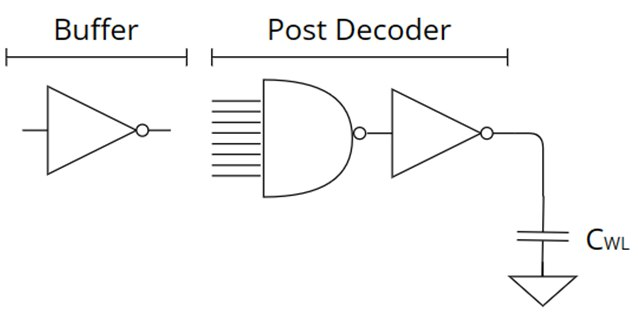

#### Define the FanIn/FanOut of the different stages

In [4]:
INPUT_BUFFER_FO = 256 // 2  # = 128
# Divided by two because every input buffer must drive only the half of the total number, 
# because we have the inverted and not inverted signal

NAND_FI = 8
NAND_FI_2ND_ARCH = 4
NAND_FI_3RD_ARCH = 2

#### Define all the gates of this architecture

In [5]:
input_buffer = Inverter("input_buffer", BETA_FIRST, BETA_OPT, 1, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)

nand_8bit_list = list()
for i in range(INPUT_BUFFER_FO):
    new_nand_8bit = Nand("nand_8bit", BETA_OPT, BETA_OPT, 1, NAND_FI, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
    nand_8bit_list.append(new_nand_8bit)

nand_8bit_branch = Branch("nand_8bit_branch", nand_8bit_list)
output_buffer = Inverter("output_buffer", BETA_OPT, BETA_OPT, 1, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)

#### Optimize the circuit size without the Pre2Post Wire

In [6]:
# Generate the circuit
rowdec_1x_gates = [input_buffer, nand_8bit_branch, output_buffer]
rowdec_1x = Circuit("RowDecoder 1x - 8bit", rowdec_1x_gates, TAU_2, TAU_RATIO, (post_WL_metal.Ctot + BITCELL_CAP) / C_GATE_INV)
rowdec_1x.info()

Circuit name: RowDecoder 1x - 8bit
╒════════════╤════════════════╤════════════════════╤═════════════════╕
│            │ input_buffer   │ nand_8bit_branch   │ output_buffer   │
╞════════════╪════════════════╪════════════════════╪═════════════════╡
│ p          │ 1.000          │ 8.000              │ 1.000           │
├────────────┼────────────────┼────────────────────┼─────────────────┤
│ g          │ 1.000          │ 3.000              │ 1.000           │
├────────────┼────────────────┼────────────────────┼─────────────────┤
│ h          │ 3.000          │ 0.333              │ 21.780          │
├────────────┼────────────────┼────────────────────┼─────────────────┤
│ b          │ 128.000        │ 1.000              │ 1.000           │
├────────────┼────────────────┼────────────────────┼─────────────────┤
│ gamma      │ 1.000          │ 1.000              │ 1.000           │
├────────────┼────────────────┼────────────────────┼─────────────────┤
│ Cin        │ 500 aF         │ 1.5 fF    

Before optimizing we can check if we need some buffers between the input buffer and the Nand

In [7]:
optimal_nb_buffer(nand_8bit_branch.C_off + input_buffer.C_load, input_buffer.C_in_gate, TAU_RATIO)

Optimal stages number (rho = 3.59) = 4.6545229480797685
the delay is expressed in multiples of TAU_2 and it's only related to the buffers
	 -> delay (exact) = 24.45371218371035
	 -> delay (N = 5) = 24.750674065955145

Optimal stages number (rho = 4) = 4.292481250360577
	 -> delay (exact) = 24.30673805692479
	 -> delay (N = 4) = 24.357435331831457

Upper even N = 6
	 -> delay = 26.1518607801068

Lower even N = 4
	 -> delay = 24.357435331831457


The optimal number of buffers is 4. Let's add them

In [8]:
buffer1 = Inverter("buffer1", BETA_OPT, BETA_OPT, 1, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
buffer2 = Inverter("buffer2", BETA_OPT, BETA_OPT, 1, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
buffer3 = Inverter("buffer3", BETA_OPT, BETA_OPT, 1, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
buffer4 = Inverter("buffer4", BETA_OPT, BETA_OPT, 1, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)

rowdec_1x_gates_buffers = [input_buffer, buffer1, buffer2, buffer3, buffer4, nand_8bit_branch, output_buffer]
rowdec_1x_buffers = Circuit("RowDecoder 1x - 8bit - buffers", rowdec_1x_gates_buffers, TAU_2, TAU_RATIO, (post_WL_metal.Ctot + BITCELL_CAP) / C_GATE_INV)
rowdec_1x_buffers.info()

Circuit name: RowDecoder 1x - 8bit - buffers
╒════════════╤════════════════╤═══════════╤═══════════╤═══════════╤═══════════╤════════════════════╤═════════════════╕
│            │ input_buffer   │ buffer1   │ buffer2   │ buffer3   │ buffer4   │ nand_8bit_branch   │ output_buffer   │
╞════════════╪════════════════╪═══════════╪═══════════╪═══════════╪═══════════╪════════════════════╪═════════════════╡
│ p          │ 1.000          │ 1.000     │ 1.000     │ 1.000     │ 1.000     │ 8.000              │ 1.000           │
├────────────┼────────────────┼───────────┼───────────┼───────────┼───────────┼────────────────────┼─────────────────┤
│ g          │ 1.000          │ 1.000     │ 1.000     │ 1.000     │ 1.000     │ 3.000              │ 1.000           │
├────────────┼────────────────┼───────────┼───────────┼───────────┼───────────┼────────────────────┼─────────────────┤
│ h          │ 1.000          │ 1.000     │ 1.000     │ 1.000     │ 3.000     │ 0.333              │ 21.780          │
├──

In [9]:
# Optimizing circuit size
rowdec_1x_opt = optimize_circuit_size(rowdec_1x_buffers)
rowdec_1x_opt.info()

Circuit name: RowDecoder 1x - 8bit - buffers_optimized
╒════════════╤════════════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤════════════════════════╤═════════════════════╕
│            │ input_buffer_opt   │ buffer1_opt   │ buffer2_opt   │ buffer3_opt   │ buffer4_opt   │ nand_8bit_branch_opt   │ output_buffer_opt   │
╞════════════╪════════════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪════════════════════════╪═════════════════════╡
│ p          │ 1.000              │ 1.000         │ 1.000         │ 1.000         │ 1.000         │ 8.000                  │ 1.000               │
├────────────┼────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼────────────────────────┼─────────────────────┤
│ g          │ 1.000              │ 1.000         │ 1.000         │ 1.000         │ 1.000         │ 3.000                  │ 1.000               │
├────────────┼────────────────────┼───────────────┼────────────

We haven't included the wiring yet, but the optimised circuit already has very large buffers. Therefore, this doesn't appear to be an ideal solution. Let's investigate alternative architectures to determine if there is any room for improvement.

## Architecture 2
The second architecture we want to explore is the following\
\
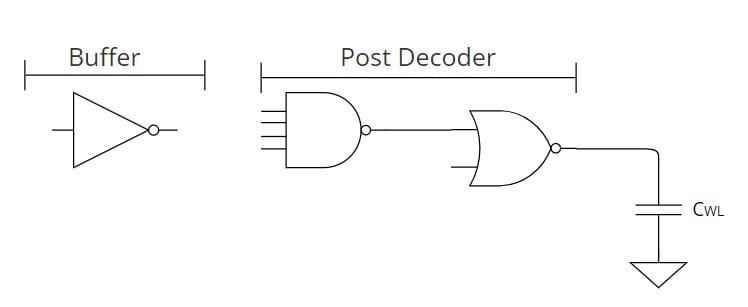
#### Define all the gates

In [10]:
nand_4bit_list = list()

for i in range(INPUT_BUFFER_FO):
    new_nand_4bit = Nand("nand_4bit" + str(i), BETA_OPT, BETA_OPT, 1, NAND_FI_2ND_ARCH, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
    nand_4bit_list.append(new_nand_4bit)

nand_4bit_branch = Branch("nand_4bit_branch", nand_4bit_list)
nor_2nd_arch = Nor("nor_2nd_arch", BETA_OPT, BETA_OPT, 1, 2, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)

#### Optimize the circuit size without the Pre2Post Wire (with buffers)

In [11]:
rowdec_1x_4bit_gates = [input_buffer, buffer1, buffer2, buffer3, buffer4, nand_4bit_branch, nor_2nd_arch]
rowdec_1x_4bit = Circuit("RowDecoder 1x - 4bit", rowdec_1x_4bit_gates, TAU_2, TAU_RATIO, (post_WL_metal.Ctot + BITCELL_CAP) / C_GATE_INV)
rowdec_1x_4bit.info()

Circuit name: RowDecoder 1x - 4bit
╒════════════╤════════════════╤═══════════╤═══════════╤═══════════╤═══════════╤════════════════════╤════════════════╕
│            │ input_buffer   │ buffer1   │ buffer2   │ buffer3   │ buffer4   │ nand_4bit_branch   │ nor_2nd_arch   │
╞════════════╪════════════════╪═══════════╪═══════════╪═══════════╪═══════════╪════════════════════╪════════════════╡
│ p          │ 1.000          │ 1.000     │ 1.000     │ 1.000     │ 1.000     │ 4.000              │ 2.000          │
├────────────┼────────────────┼───────────┼───────────┼───────────┼───────────┼────────────────────┼────────────────┤
│ g          │ 1.000          │ 1.000     │ 1.000     │ 1.000     │ 1.000     │ 1.857              │ 1.714          │
├────────────┼────────────────┼───────────┼───────────┼───────────┼───────────┼────────────────────┼────────────────┤
│ h          │ 1.000          │ 1.000     │ 1.000     │ 1.000     │ 1.857     │ 0.923              │ 12.705         │
├────────────┼───────

Optimize the size of the circuit

In [12]:
rowdec_1x_4bit_opt = optimize_circuit_size(rowdec_1x_4bit)
rowdec_1x_4bit_opt.info()

Circuit name: RowDecoder 1x - 4bit_optimized
╒════════════╤════════════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤════════════════════════╤════════════════════╕
│            │ input_buffer_opt   │ buffer1_opt   │ buffer2_opt   │ buffer3_opt   │ buffer4_opt   │ nand_4bit_branch_opt   │ nor_2nd_arch_opt   │
╞════════════╪════════════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪════════════════════════╪════════════════════╡
│ p          │ 1.000              │ 1.000         │ 1.000         │ 1.000         │ 1.000         │ 4.000                  │ 2.000              │
├────────────┼────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼────────────────────────┼────────────────────┤
│ g          │ 1.000              │ 1.000         │ 1.000         │ 1.000         │ 1.000         │ 1.857                  │ 1.714              │
├────────────┼────────────────────┼───────────────┼───────────────┼────────────

Here again, we haven't included the wiring yet, but the optimised circuit already has very large buffers. Therefore, this doesn't appear to be, again, an ideal solution. Let's investigate the third architecture to determine if there is any room for improvement.

## Architecture 3 - 2bit Nand
The 3rd and last architecture presented for the 1x RowDecoder is the following\
\
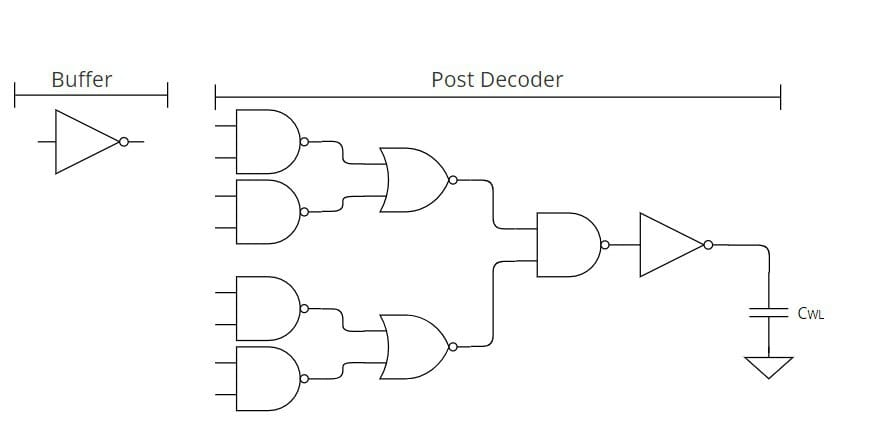
#### Define all the gates

In [13]:
nand_2bit_list = list()

for i in range(INPUT_BUFFER_FO):
    new_nand_2bit = Nand("nand_" + str(i), BETA_OPT, BETA_OPT, 1 , NAND_FI_3RD_ARCH, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
    nand_2bit_list.append(new_nand_2bit)

nand_2bit_branch = Branch("nand_2bit_branch", nand_2bit_list)

nor_3rd_arch = Nor("nor_3rd_arch", BETA_OPT, BETA_OPT, 1, 2, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
nand_3rd_arch = Nand("nand_3rd_arch", BETA_OPT, BETA_OPT, 1, 2, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
inv_3rd_arch = Inverter("inv_3rd_arch", BETA_OPT, BETA_OPT, 1, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)

#### Optimize the circuit size without the Pre2Post Wire (with buffers)

In [14]:
rowdec_1x_2bit_gates = [input_buffer, buffer1, buffer2, buffer3, buffer4, nand_2bit_branch, nor_3rd_arch, nand_3rd_arch, inv_3rd_arch]
rowdec_1x_2bit = Circuit("RowDecoder 1x - 2bit", rowdec_1x_2bit_gates, TAU_2, TAU_RATIO, (post_WL_metal.Ctot + BITCELL_CAP) / C_GATE_INV)
rowdec_1x_2bit.info()

Circuit name: RowDecoder 1x - 2bit
╒════════════╤════════════════╤═══════════╤═══════════╤═══════════╤═══════════╤════════════════════╤════════════════╤═════════════════╤════════════════╕
│            │ input_buffer   │ buffer1   │ buffer2   │ buffer3   │ buffer4   │ nand_2bit_branch   │ nor_3rd_arch   │ nand_3rd_arch   │ inv_3rd_arch   │
╞════════════╪════════════════╪═══════════╪═══════════╪═══════════╪═══════════╪════════════════════╪════════════════╪═════════════════╪════════════════╡
│ p          │ 1.000          │ 1.000     │ 1.000     │ 1.000     │ 1.000     │ 2.000              │ 2.000          │ 2.000           │ 1.000          │
├────────────┼────────────────┼───────────┼───────────┼───────────┼───────────┼────────────────────┼────────────────┼─────────────────┼────────────────┤
│ g          │ 1.000          │ 1.000     │ 1.000     │ 1.000     │ 1.000     │ 1.286              │ 1.714          │ 1.286           │ 1.000          │
├────────────┼────────────────┼───────────┼────

In [15]:
rowdec_1x_2bit_opt = optimize_circuit_size(rowdec_1x_2bit)
rowdec_1x_2bit_opt.info()

Circuit name: RowDecoder 1x - 2bit_optimized
╒════════════╤════════════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╤════════════════════════╤════════════════════╤═════════════════════╤════════════════════╕
│            │ input_buffer_opt   │ buffer1_opt   │ buffer2_opt   │ buffer3_opt   │ buffer4_opt   │ nand_2bit_branch_opt   │ nor_3rd_arch_opt   │ nand_3rd_arch_opt   │ inv_3rd_arch_opt   │
╞════════════╪════════════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╪════════════════════════╪════════════════════╪═════════════════════╪════════════════════╡
│ p          │ 1.000              │ 1.000         │ 1.000         │ 1.000         │ 1.000         │ 2.000                  │ 2.000              │ 2.000               │ 1.000              │
├────────────┼────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┼────────────────────────┼────────────────────┼─────────────────────┼────────────────────┤
│ g       

Here the size are better, so we can try to see what happens if we add the Pre2Post Wire

In [16]:
GAMMA_NAND_BRANCH_POST = 1
GAMMA_NOR_POST_1 = 2
GAMMA_NAND_POST_2 = 3
GAMMA_INV_POST = 8

We chosed to include the wire as an equivalent fanout to the gate that drives the wire

In [17]:
# Real size nand
nand = Nand("nand", BETA_OPT, BETA_OPT, GAMMA_NAND_BRANCH_POST, NAND_FI_3RD_ARCH, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)

# If we increase the fanout of the sized nand to achieve a Coff that is Coff_branch + Cwire
additional_FO = round(pre_post_metal.Ctot / nand.C_in_gate)
print(f"Additional Nand FanOut = {additional_FO}")

Additional Nand FanOut = 59


Create the final PostDecoder, including the wire

In [18]:
nand_branch_with_wire = list()
for i in range(INPUT_BUFFER_FO + additional_FO):
    nand_1x_postDec =  Nand("nand_4x_post_" + str(i), BETA_OPT, BETA_OPT, GAMMA_NAND_BRANCH_POST, NAND_FI_3RD_ARCH, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
    nand_branch_with_wire.append(nand_1x_postDec)

nand_branch_wire = Branch("nand_post", nand_branch_with_wire)

nor_3rd_final = Nor("nor_3rd_final", BETA_OPT, BETA_OPT, GAMMA_NOR_POST_1, 2, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
nand_3rd_final = Nand("nand_3rd_final", BETA_OPT, BETA_OPT, GAMMA_NAND_POST_2, 2, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
inv_3rd_final = Inverter("inv_3rd_final", BETA_OPT, BETA_OPT, GAMMA_INV_POST, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)

Creating the predecoder circuit with the actual load (in this case the predecoder is only a suite of buffers)

In [19]:
predec_gates = [input_buffer, buffer1, buffer2, buffer3, buffer4]
predec = Circuit("predec", predec_gates, TAU_2, TAU_RATIO, (nand_branch_wire.C_in_gate + nand_branch_wire.C_off) / C_GATE_INV)
predec.info()

Circuit name: predec
╒════════════╤════════════════╤═══════════╤═══════════╤═══════════╤═══════════╕
│            │ input_buffer   │ buffer1   │ buffer2   │ buffer3   │ buffer4   │
╞════════════╪════════════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ p          │ 1.000          │ 1.000     │ 1.000     │ 1.000     │ 1.000     │
├────────────┼────────────────┼───────────┼───────────┼───────────┼───────────┤
│ g          │ 1.000          │ 1.000     │ 1.000     │ 1.000     │ 1.000     │
├────────────┼────────────────┼───────────┼───────────┼───────────┼───────────┤
│ h          │ 1.000          │ 1.000     │ 1.000     │ 1.000     │ 240.429   │
├────────────┼────────────────┼───────────┼───────────┼───────────┼───────────┤
│ b          │ 1.000          │ 1.000     │ 1.000     │ 1.000     │ 128.000   │
├────────────┼────────────────┼───────────┼───────────┼───────────┼───────────┤
│ gamma      │ 1.000          │ 1.000     │ 1.000     │ 1.000     │ 1.000     │
├────────────┼─────

In [20]:
predec_opt = optimize_circuit_size(predec)
predec_opt.info()

Circuit name: predec_optimized
╒════════════╤════════════════════╤═══════════════╤═══════════════╤═══════════════╤═══════════════╕
│            │ input_buffer_opt   │ buffer1_opt   │ buffer2_opt   │ buffer3_opt   │ buffer4_opt   │
╞════════════╪════════════════════╪═══════════════╪═══════════════╪═══════════════╪═══════════════╡
│ p          │ 1.000              │ 1.000         │ 1.000         │ 1.000         │ 1.000         │
├────────────┼────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ g          │ 1.000              │ 1.000         │ 1.000         │ 1.000         │ 1.000         │
├────────────┼────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ h          │ 2.994              │ 2.994         │ 2.994         │ 2.994         │ 2.994         │
├────────────┼────────────────────┼───────────────┼───────────────┼───────────────┼───────────────┤
│ b          │ 1.000              │ 1.000         │ 1.000         │ 1

In [21]:
GAMMA_BUFFER_1 = 3
GAMMA_BUFFER_2 = 9
GAMMA_BUFFER_3 = 27
GAMMA_BUFFER_4 = 80

Final circuit

In [22]:
buffer1_final = Inverter("buffer1", BETA_OPT, BETA_OPT, GAMMA_BUFFER_1, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
buffer2_final = Inverter("buffer2", BETA_OPT, BETA_OPT, GAMMA_BUFFER_2, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
buffer3_final = Inverter("buffer3", BETA_OPT, BETA_OPT, GAMMA_BUFFER_3, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)
buffer4_final = Inverter("buffer4", BETA_OPT, BETA_OPT, GAMMA_BUFFER_4, DUMMY_METAL, C_INT_TRANS, TAU_RATIO)

rowdec_1x_final_gates = [input_buffer, buffer1_final, buffer2_final, buffer3_final, buffer4_final, nand_branch_wire, nor_3rd_final, nand_3rd_final, inv_3rd_final]

rowdec_1x_final = Circuit("RowDecoder 1x - Final", rowdec_1x_final_gates, TAU_2, TAU_RATIO, (post_WL_metal.Ctot + BITCELL_CAP) / C_GATE_INV)
rowdec_1x_final.info()

Circuit name: RowDecoder 1x - Final
╒════════════╤════════════════╤═══════════╤═══════════╤═══════════╤═══════════╤═════════════╤═════════════════╤══════════════════╤═════════════════╕
│            │ input_buffer   │ buffer1   │ buffer2   │ buffer3   │ buffer4   │ nand_post   │ nor_3rd_final   │ nand_3rd_final   │ inv_3rd_final   │
╞════════════╪════════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═════════════╪═════════════════╪══════════════════╪═════════════════╡
│ p          │ 1.000          │ 1.000     │ 1.000     │ 1.000     │ 1.000     │ 2.000       │ 2.000           │ 2.000            │ 1.000           │
├────────────┼────────────────┼───────────┼───────────┼───────────┼───────────┼─────────────┼─────────────────┼──────────────────┼─────────────────┤
│ g          │ 1.000          │ 1.000     │ 1.000     │ 1.000     │ 1.000     │ 1.286       │ 1.714           │ 1.286            │ 1.000           │
├────────────┼────────────────┼───────────┼───────────┼───────────┼───

The delay is very interesting, but the size are, sometimes, too big (problems with pitch-matching for example). Let's see if with other architectures we can achieve better results

The final architecture of the RowDecoder 1x is the following\
\
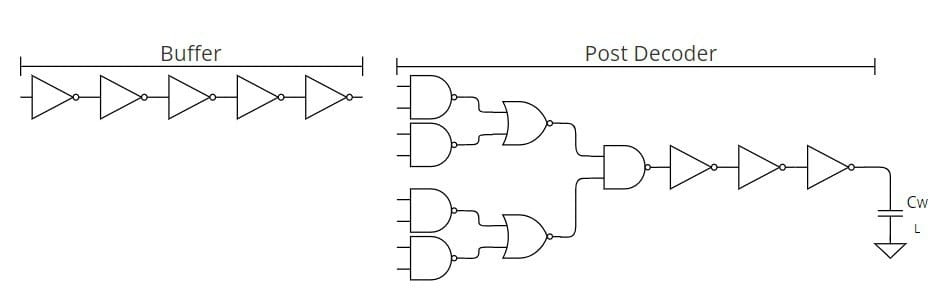

The total delay is

In [23]:
total_delay = rowdec_1x_final.delay + pre_post_metal.tau + post_WL_metal.tau
print(f"Total delay = {str(Quantity(total_delay, 's'))}")

Total delay = 171.53 ps
